# Plotting Werner solutions and lines on map 

#### Import packages and data

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy.interpolate 
import pygmt
from matplotlib import gridspec
import matplotlib.image as mpimg
import geopandas as gpd

In [40]:
cd

C:\Users\matthewt


In [41]:
cd Documents\Python_Scripts\GRL_2021_Figures

C:\Users\matthewt\Documents\Python_Scripts\GRL_2021_Figures


#### Load OIB and ROSETTA werner solutions

In [42]:
rosetta_werner_all_points = pd.read_csv('ROSETTA_Werner_all_points.csv',header=0,index_col=None,sep=',')
rosetta_werner_binned_points = pd.read_csv('ROSETTA_Werner_binned_points.csv',header=0,index_col=None,sep=',')
oib_all_points = pd.read_csv('OIB_Werner_all_points.csv',header=0,index_col=None,sep=',')
oib_binned_points = pd.read_csv('OIB_Werner_binned_points.csv',header=0,index_col=None,sep=',')

rosetta_590_all_points=rosetta_werner_all_points[rosetta_werner_all_points.Line==590]
rosetta_590_binned_points=rosetta_werner_binned_points[rosetta_werner_binned_points.Line==590]

rosetta_650_all_points=rosetta_werner_all_points[rosetta_werner_all_points.Line==650]
rosetta_650_binned_points=rosetta_werner_binned_points[rosetta_werner_binned_points.Line==650]

oib_590_all_points=oib_all_points[oib_all_points.Line==404.590]
oib_590_binned_points=oib_binned_points[oib_binned_points.Line==404.590]

oib_650_all_points=oib_all_points[oib_all_points.Line==404.650]
oib_650_binned_points=oib_binned_points[oib_binned_points.Line==404.650]

In [43]:
x1 = min(rosetta_650_all_points.Distance)
x2 = max(rosetta_650_all_points.Distance) 
x_new_step = 5000
x_new = np.arange(x1, x2, x_new_step)  # creates array for distance to interpolate onto, 1 point every 10km
window = int(30_000/x_new_step)

f = scipy.interpolate.interp1d(rosetta_650_binned_points.Distance, rosetta_650_binned_points.Depth_sl_36k, kind='quadratic', fill_value='extrapolate') 
interp=f(x_new) 
interp_data={'Distance':x_new, 'interp':interp}
df_interp=pd.DataFrame(data=interp_data)
df_interp['filt'] = df_interp.interp.rolling(window, center=True).mean()
df_interp.sort_values(['Distance'], inplace=True)
df=rosetta_650_all_points.set_index('Distance').join(df_interp.set_index('Distance'), how='outer')
df.reset_index(inplace=True)
df.sort_values(['Distance'])

df.x.interpolate(method='linear', inplace=True)
df.y.interpolate(method='linear', inplace=True)

rosetta_650_all_points_just_line=df.drop(df.columns.difference(['x', 'y', 'filt', 'Distance']), 1)
rosetta_650_all_points_just_line.sort_values(['Distance'])
rosetta_650_all_points_just_line=rosetta_650_all_points_just_line[rosetta_650_all_points_just_line.filt.notna()]

oib_650_all_points_just_line=oib_650_all_points.drop(oib_650_all_points.columns.difference(['x', 'y', 'filt', 'Distance']), 1)
oib_650_all_points_just_line.sort_values(['Distance'])
oib_650_all_points_just_line=oib_650_all_points_just_line[oib_650_all_points_just_line.filt.notna()]

## Plot Grid with ROSETTA flight lines 

In [44]:
figheight=180 # in mm
#RIS extent
ris_xl=-660_000
ris_yl=-1_500_000
ris_xh=470_000
ris_yh=-400_000

figwidth=figheight*(ris_xh-ris_xl)/(ris_yh-ris_yl)
risratio = (ris_yh - ris_yl) / (figheight/1000)
risreg = str(ris_xl) + '/' + str(ris_xh) + '/' + str(ris_yl) + '/' + str(ris_yh) #W/E/S/N
risproj = "x1:" + str(risratio)
risproj_ll = "s0/-90/-71/1:" + str(risratio)

def make_grid(lines, region=risreg, projection=risproj, save_as_png=True):
    global fig
    fig = pygmt.Figure()
    rosetta_flights=rosetta_werner_all_points[rosetta_werner_all_points.Line.isin(lines)].copy()
    binned_points=rosetta_werner_binned_points[rosetta_werner_binned_points.Line.isin(lines)].copy()

    rosetta_flights.drop(rosetta_flights.columns.difference(['x','y','Line']),1, inplace=True)
    rosetta_flights.dropna(inplace=True)
    rosetta_flights.drop_duplicates(inplace=True)
    rosetta_flights['Line']=rosetta_flights['Line'].apply(np.int64)
    rosetta_lines=rosetta_flights[rosetta_flights.Line<1000].copy()

    subset_lines = [v for _, v in rosetta_lines.groupby('Line')]

    rosetta_all_flights = rosetta_werner_all_points[~rosetta_werner_all_points.Line.isin(lines)].copy()
    rosetta_all_flights.drop(rosetta_all_flights.columns.difference(['x','y','Line']),1, inplace=True)
    rosetta_all_flights.dropna(inplace=True)
    rosetta_all_flights.drop_duplicates(inplace=True)
    rosetta_all_flights=rosetta_all_flights[~((rosetta_all_flights.Line==403) | (rosetta_all_flights.Line==404) | (rosetta_all_flights.Line==999))]
    rosetta_all_flights['Line']=rosetta_all_flights['Line'].apply(np.int64)
    rosetta_all_ties=rosetta_all_flights[rosetta_all_flights.Line>=1000]
    rosetta_all_lines=rosetta_all_flights[rosetta_all_flights.Line<1000]

    all_lines = [v for _, v in rosetta_all_lines.groupby('Line')]
    all_ties = [v for _, v in rosetta_all_ties.groupby('Line')]
    
    with pygmt.config(MAP_FRAME_TYPE = 'inside'):
        fig.coast(region = risreg, projection = risproj_ll, land = 'grey', water = 'grey', frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')
     # Plot graticules overtop, at 2d latitude and 15d longitude
    with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                      MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black',  
                      MAP_GRID_PEN_PRIMARY = 'black', MAP_TICK_LENGTH_PRIMARY = '-10p',
                      MAP_TICK_PEN_PRIMARY = 'thinnest,black', FORMAT_GEO_MAP = 'dddF',
                      MAP_POLAR_CAP = '90/90'):
        fig.basemap(projection = risproj_ll, region = risreg,
                    frame = ["NSWE", "xa15g15", "ya2g2"],verbose='e') 
    
    fig.grdimage(projection = risproj, grid = 'tmp/tmp_rosetta_werner_surface_masked.nc', cmap = 'cpts/RIS_basement.cpt', shading = 'grdgradient+a45+ne.5+m-.4', nan_transparent=True)

    # Plot the grounding/coast lines
    fig.plot(data=gpd.read_file('../shapefiles/MEaSUREs_groundingline.shp') , region = risreg, projection = risproj, pen = '0.5p,black', verbose='e')
    fig.plot(data=gpd.read_file('../shapefiles/MEaSUREs_coastline.shp'), pen='0.5p,black', verbose='e')

    # Plot EANT/WANT Divide
    fig.plot(data=gpd.read_file('../shapefiles/EANT_WANT_divide.shp'), pen='thickest,black') 

    # COLORBAR
    barwidth = figwidth/10 * 0.4 # color bar width is 40% of the map width, in cm
    pos_str = 'jTR+w' + str(barwidth) + 'c/.5c+jTR+o1c/1c+h+ml+e'
    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '16p,black'):
        fig.colorbar(cmap = 'cpts/RIS_basement.cpt', position = pos_str, 
                     frame = ['xa1000+f500+l"Depth to basement (mbsl)"'], 
                     box = '+gwhite+p0.5p,black+c3p', verbose='e')

    # SCALEBAR
    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '12p,black', MAP_SCALE_HEIGHT='5p', MAP_TICK_PEN_PRIMARY = '0.5p,black'):
        fig.basemap(region = risreg, projection = risproj_ll, map_scale='jMB+w400k+c170E/71S+f+l"km"+ar+o3c/0.5c', verbose='e')
    # all tie lines and labels
    for i in list(range(len(all_ties))): 
        fig.plot(region=risreg, projection=risproj, x=all_ties[i].x,y=all_ties[i].y, pen='0.3p,white') 
        if rosetta_all_ties.Line.unique()[i]==1000:#i==0:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/0.5c', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1030:#i==2:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='-0.2c/0.4+v0.2p,white,.', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1040:#i==4:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/1.2+v0.2p,white,.', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1050:#i==4:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/1.2+v0.2p,white,.', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1110:#i==4:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/1.2+v0.2p,white,.', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1140:#i==12:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/1.4+v0.2p,white,.', fill='white')
        else:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/0.8+v0.2p,white,.',fill='white')
    # all lines and labels except for subset
    for i in list(range(len(all_lines))): 
        fig.plot(x=all_lines[i].x, y=all_lines[i].y, pen='0.3p,white') 
        if (i%2) ==0:
            fig.text(x=all_lines[i].x.loc[all_lines[i].x.idxmax()], 
                     y=all_lines[i].y.loc[all_lines[i].x.idxmax()], 
                     text=str(all_lines[i].Line.iloc[0]), 
                     justify='CM', font='5p,black', fill='white', offset='0.2c/0.0c')
        else:
            fig.text(x=all_lines[i].x.loc[all_lines[i].x.idxmin()], 
                     y=all_lines[i].y.loc[all_lines[i].x.idxmin()], 
                     text=str(all_lines[i].Line.iloc[0]), 
                     justify='CM', font='5p,black', fill='white', offset='-0.2c/0.0c')     
    # all binned points
    fig.plot(region=risreg, projection=risproj,
             data="rosetta_werner_block.txt",
                style='c.07c',
                color='black',
                pen='black')   
    # choosen lines and labels
    for i in list(range(len(subset_lines))): 
        fig.plot(x=subset_lines[i].x, y=subset_lines[i].y, pen='1.4p,white') 
        if (i%2) ==0:
            fig.text(x=subset_lines[i].x.loc[subset_lines[i].x.idxmax()], 
                     y=subset_lines[i].y.loc[subset_lines[i].x.idxmax()], 
                     text=str(subset_lines[i].Line.iloc[0]), 
                     justify='CM', font='10p,black', fill='white', offset='0.6c/0.0c')
        else:
            fig.text(x=subset_lines[i].x.loc[subset_lines[i].x.idxmin()], 
                     y=subset_lines[i].y.loc[subset_lines[i].x.idxmin()], 
                     text=str(subset_lines[i].Line.iloc[0]), 
                     justify='CM', font='10p,black', fill='white', offset='-0.6c/0.0c')
    # choosen binned points, colored
    fig.plot(x=binned_points.x,
             y=binned_points.y, 
             style = 'c.3c', 
             pen='thin,black',
             color=binned_points.Depth_sl_36k,
             cmap="cpts\RIS_basement.cpt")

    if save_as_png==True:
        out='..\..\Manuscripts\GRL_Mag_Basement_2020\FigS4_unfiltered_basement.jpg'
        fig.savefig(out, dpi=1000)

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


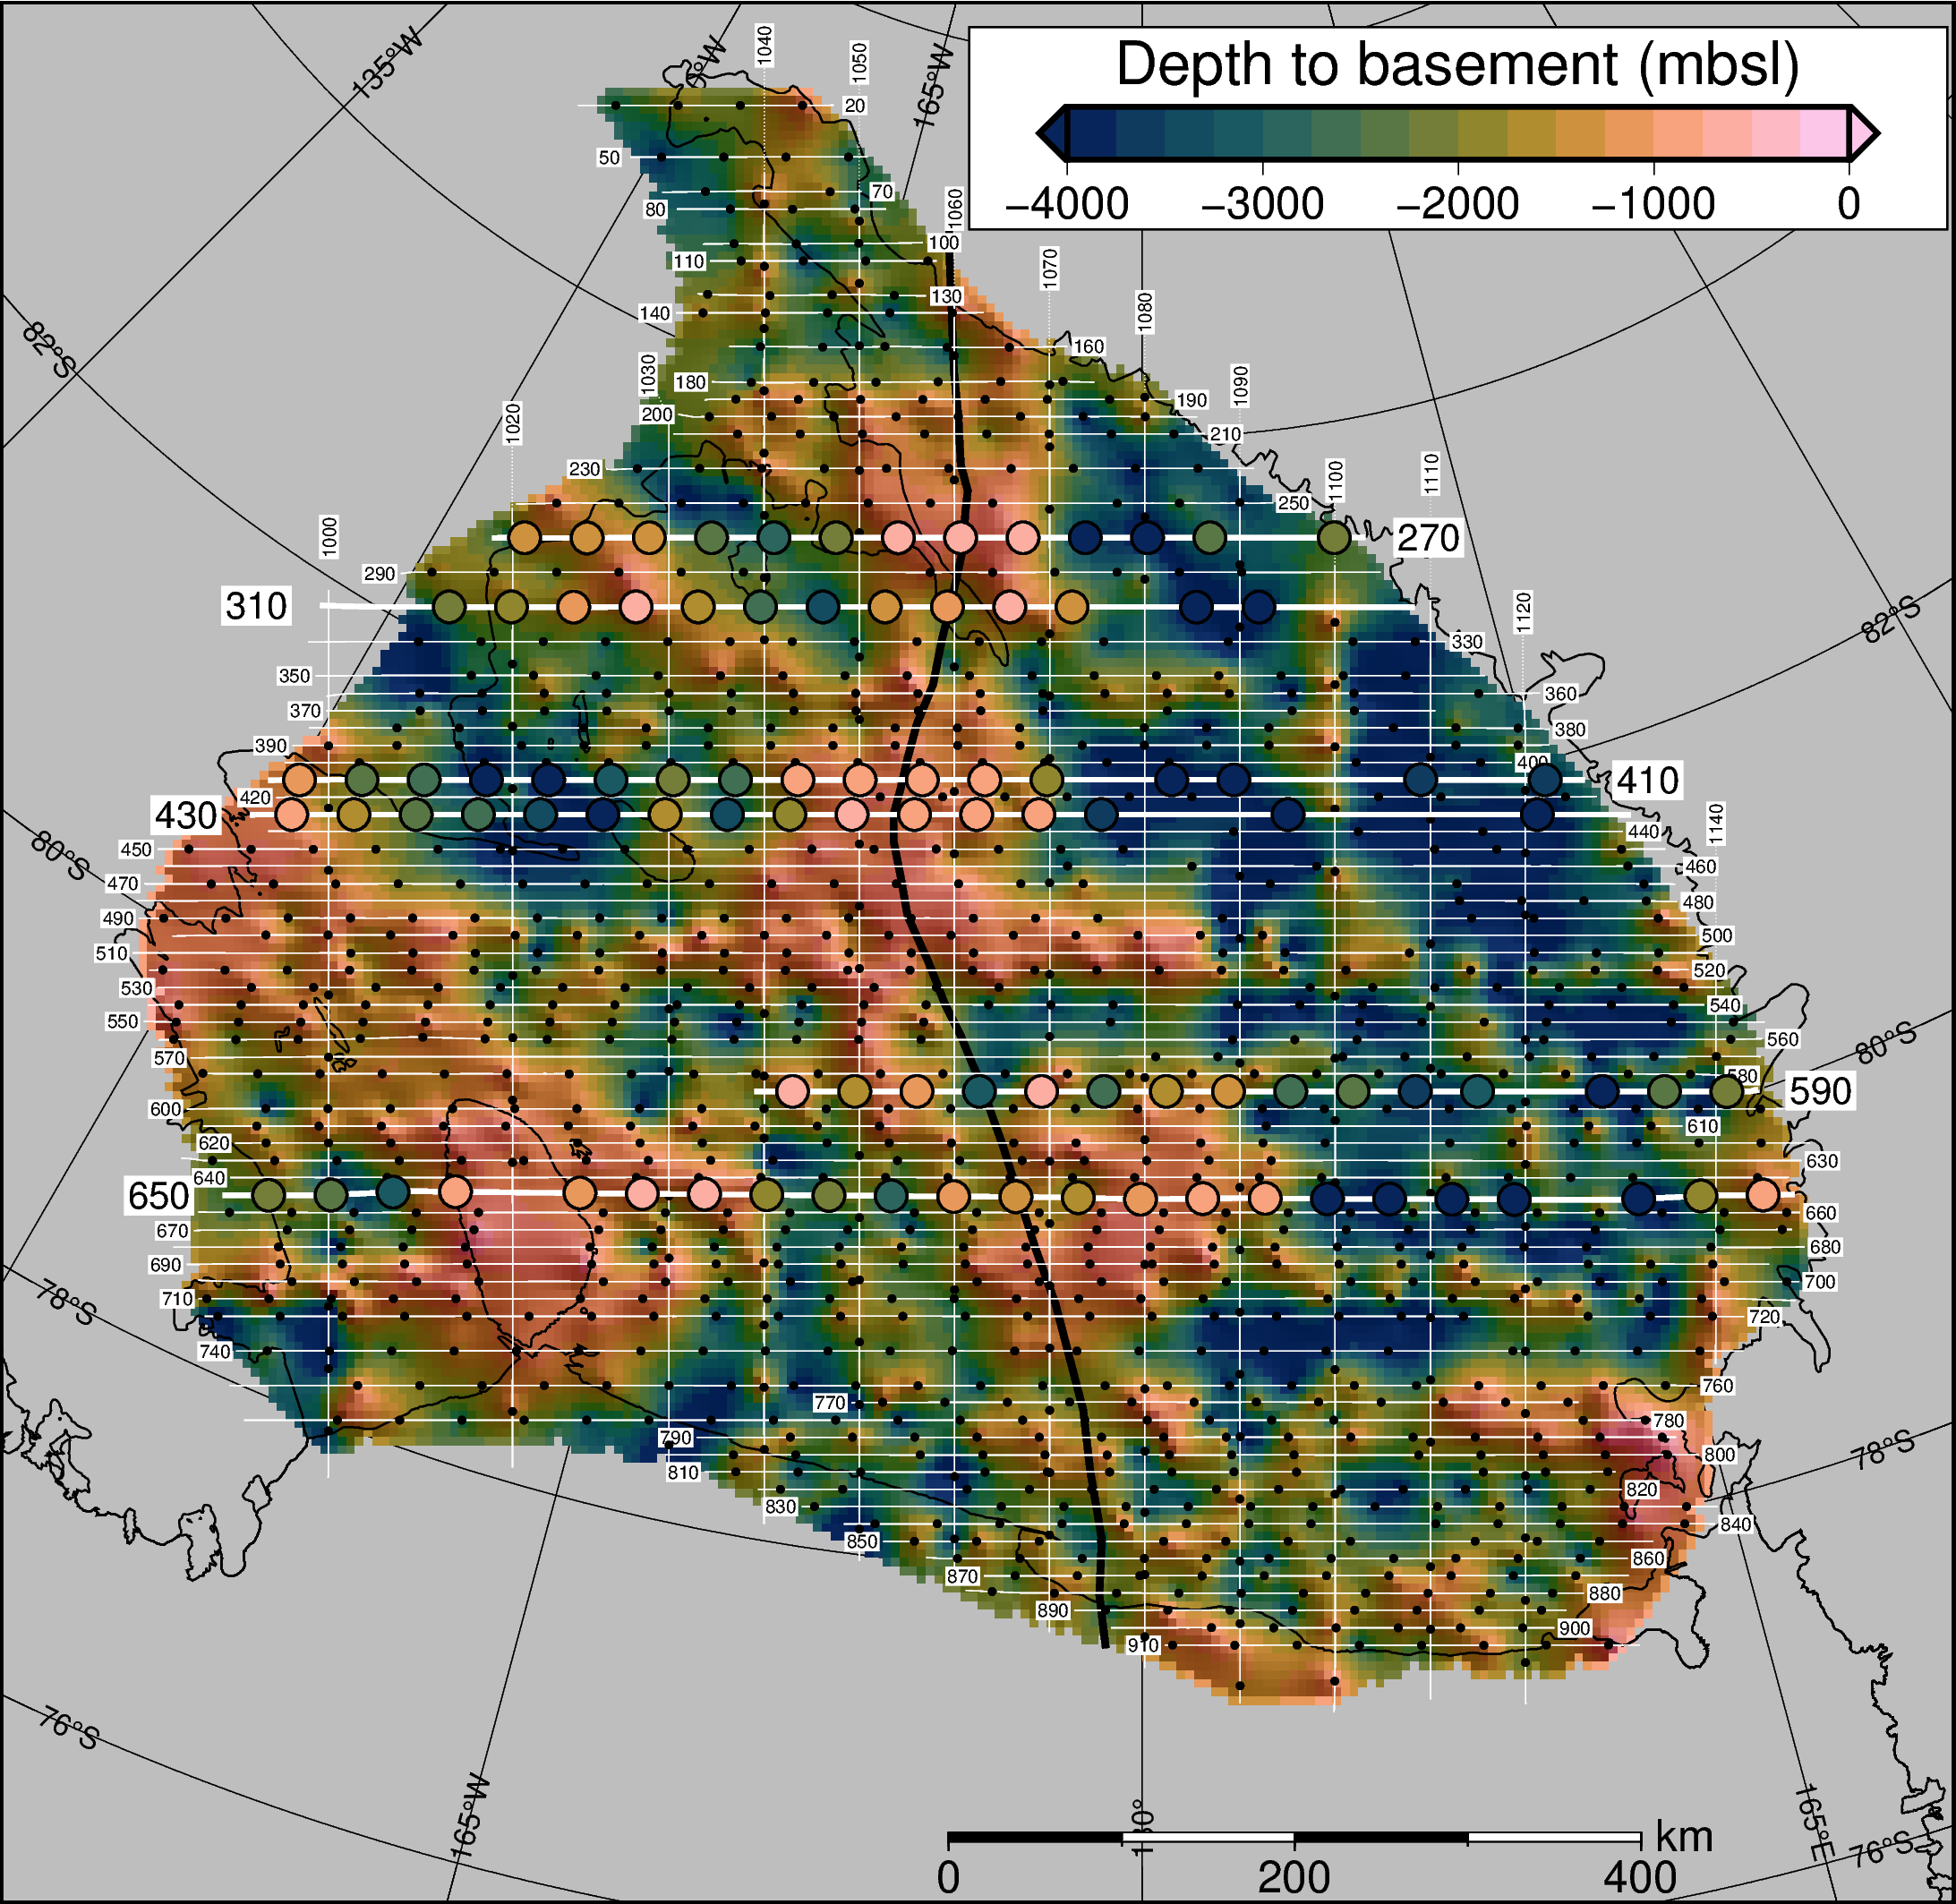

In [45]:
make_grid(lines=(270,310,410,430,590,650), region=risreg, projection=risproj, save_as_png=True)
fig.show()